In [84]:
import numpy as np
import pandas as pd
import seaborn as sns
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials
import sys

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from ipywidgets import widgets, interactive
import plotly.figure_factory as ff
import plotly.graph_objs as go
from IPython.display import HTML
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# Spotify Audio Feature Analysis

I was curious about what Spotify's API wass like, and what features it had for musical analysis. There are a lot of thoughts I have regarding musical analysis,a and I wanted to see if I could find data-driven insights regarding how we listen to our music. We will have the opportunity to apply what we have here to different Spotify-related projects.

To begin, you will need to go to [Spotify's Developers page](https://developer.spotify.com/discover/). Follow the instructions to sign up to be a developer, which will connect with your Spotify account. From there you can get credentials that you will need for the following script. The page also has further information on the features that we will be analyzing.

The first script below is what I used to utilize the spotify app. However, because you need client credentials, I left the client_id and client_secret blank for the user to fill out. I use the script below that to get my access to the API. It won't work for you to run it.

In [32]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

client_credentials_manager = SpotifyClientCredentials(client_id='FILL IN THE BLANK',
                            client_secret='FILL IN THE BLANK')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

playlists = sp.user_playlists('spotify')
#while playlists:
#    for i, playlist in enumerate(playlists['items']):
#        print("%4d %s %s" % (i + 1 + playlists['offset'], playlist['uri'],  playlist['name']))
#    if playlists['next']:
#        playlists = sp.next(playlists)
#    else:
#        playlists = None

In [14]:
%run -i 'client_id_script.py'

## Artist Analysis

At this point there are a lot of avenues one can take to explore Spotify's vast collection of data. You can explore your own personal usage data, or you can explore artists and data related to their music. For the time being, we will do the latter.

I created a few functions that will make it easier to navigate exploring an artist's songs and albums.

In [101]:
# obtains the artist_id of a desired artist
def get_artist(name):
    results = sp.search(q='artist:' + name, type='artist')
    items = results['artists']['items']
    if len(items) > 0:
        return items[0]
    else:
        return None

In [96]:
# obtains all the albums assoiated with a particular artist
def artist_albums(name):
    albums = pd.DataFrame(columns = ["Album Name", "Album URI"])
    i = 0
    for album in sp.artist_albums(get_artist(name)["uri"])["items"]:
        if album["album_type"] == 'single':
            continue
        to_append = [album["name"], album["uri"]]
        albums.loc[i] = to_append
        i += 1
    return albums

In [94]:
# retrieves audio features for an album given the album uri
def album_audio_features(album_uri):
    audio = pd.DataFrame()
    for song in sp.album_tracks(album_uri)['items']:
        df = pd.DataFrame([sp.audio_features(song["uri"])[0]])
        df["Name"] = song["name"]
        cols = df.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        df = df[cols]
        if audio.empty:
            audio = df
        else:
            audio = pd.concat([audio, df])
    audio = audio.reset_index(drop=True)
    return audio

In [16]:
# obtains the audio features of every song by the artist on Spotify
# note: takes a while to run per artist
def get_artist_audio_features(name):
    uri = get_artist(name)["uri"]
    artist = pd.DataFrame()
    for album in sp.artist_albums(uri)["items"]:
        for song in sp.album_tracks(album["uri"])["items"]:
            df = pd.DataFrame([sp.audio_features(song["uri"])[0]])
            df["Name"] = song["name"]
            cols = df.columns.tolist()
            cols = cols[-1:] + cols[:-1]
            df = df[cols]
            if artist.empty:
                artist = df
            else:
                artist = pd.concat([artist, df])
    return artist

Below we will show examples of what it looks like to use these functions:

In [97]:
artist_albums("John Mayer")

,Album Name,Album URI
0,The Search for Everything,spotify:album:0jZFu2tihRJ65iYAo0oOtP
1,Paradise Valley,spotify:album:712VoD72K500yLhhgqCyVe
2,Born and Raised,spotify:album:6S0BIiWtnqU0PtumXMpin0
3,Battle Studies,spotify:album:1V5vQRMWTNGmqwxY8jMVou
4,Where the Light Is: John Mayer Live In Los Ang...,spotify:album:4Dgxy95K9BWkDUvQPTaYBb
5,Continuum,spotify:album:1Xsprdt1q9rOzTic7b9zYM
6,As/Is,spotify:album:1QRIX6BuSGegYwiAZOv4R5
7,"As/Is: Cleveland/Cincinnati, OH - 8/03-8/04/04",spotify:album:0u3x6X6FRE23fJEhPJoo6Q
8,"As/Is: Houston, TX - 7/24/04",spotify:album:4rBHg7R3tDXJirsOrp4vG4
9,"As/Is: Philadelphia, PA/Hartford, CT - 8/14-8/...",spotify:album:1hC2L9ZBeCSUsh6w3xzqN7


In [100]:
album_audio_features('spotify:album:3yHOaiXecTJVUdn7mApZ48').head()

,Name,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,No Such Thing,0.0383,https://api.spotify.com/v1/audio-analysis/6Vec...,0.668,231467,0.739,6Vecwo7AHst9V2CE3kmwr0,0.000000,4,0.1300,-4.919,1,0.0308,131.918,4,https://api.spotify.com/v1/tracks/6Vecwo7AHst9...,audio_features,spotify:track:6Vecwo7AHst9V2CE3kmwr0,0.571
1,Why Georgia,0.0208,https://api.spotify.com/v1/audio-analysis/1c7U...,0.608,268973,0.639,1c7UYTut2SBOPq64o2t0uN,0.000059,7,0.0893,-7.205,1,0.0246,96.915,4,https://api.spotify.com/v1/tracks/1c7UYTut2SBO...,audio_features,spotify:track:1c7UYTut2SBOPq64o2t0uN,0.369
2,My Stupid Mouth,0.0143,https://api.spotify.com/v1/audio-analysis/3jFP...,0.608,223960,0.603,3jFP1e8IUpD9QbltEI1Hcg,0.000012,2,0.0833,-6.792,1,0.0271,88.824,4,https://api.spotify.com/v1/tracks/3jFP1e8IUpD9...,audio_features,spotify:track:3jFP1e8IUpD9QbltEI1Hcg,0.490
3,Your Body Is a Wonderland,0.0206,https://api.spotify.com/v1/audio-analysis/7vFv...,0.647,249627,0.729,7vFv0yFGMJW3qVXbAd9BK9,0.048900,5,0.1340,-6.251,1,0.0236,94.010,4,https://api.spotify.com/v1/tracks/7vFv0yFGMJW3...,audio_features,spotify:track:7vFv0yFGMJW3qVXbAd9BK9,0.687
4,Neon,0.0181,https://api.spotify.com/v1/audio-analysis/7Koh...,0.699,262107,0.770,7Kohy4v3KLWfUXlv9N3feB,0.000138,5,0.0644,-7.658,0,0.0360,101.984,4,https://api.spotify.com/v1/tracks/7Kohy4v3KLWf...,audio_features,spotify:track:7Kohy4v3KLWfUXlv9N3feB,0.589


In [99]:
jmayer = get_artist_audio_features("John Mayer")
jmayer.head()

,Name,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,Still Feel Like Your Man,0.547,https://api.spotify.com/v1/audio-analysis/1LM6...,0.858,234920,0.600,1LM6t24SjQr2bJHqeGIR4U,0.001130,2,0.1320,-6.677,1,0.0630,106.023,4,https://api.spotify.com/v1/tracks/1LM6t24SjQr2...,audio_features,spotify:track:1LM6t24SjQr2bJHqeGIR4U,0.513
0,Emoji of a Wave,0.771,https://api.spotify.com/v1/audio-analysis/5ddX...,0.494,239667,0.365,5ddXMXmXZ2FN4iliTG20nO,0.000978,11,0.1390,-8.920,1,0.0279,165.766,4,https://api.spotify.com/v1/tracks/5ddXMXmXZ2FN...,audio_features,spotify:track:5ddXMXmXZ2FN4iliTG20nO,0.191
0,Helpless,0.151,https://api.spotify.com/v1/audio-analysis/701D...,0.761,249120,0.598,701DK0It9f7iurRnzKvF0y,0.002590,9,0.0314,-5.838,0,0.0268,103.978,4,https://api.spotify.com/v1/tracks/701DK0It9f7i...,audio_features,spotify:track:701DK0It9f7iurRnzKvF0y,0.937
0,Love on the Weekend,0.623,https://api.spotify.com/v1/audio-analysis/0oiC...,0.718,212320,0.583,0oiCeOPwm4zhwfyIpAE37y,0.000662,7,0.0612,-7.884,1,0.0288,119.970,4,https://api.spotify.com/v1/tracks/0oiCeOPwm4zh...,audio_features,spotify:track:0oiCeOPwm4zhwfyIpAE37y,0.422
0,In the Blood,0.386,https://api.spotify.com/v1/audio-analysis/77Y5...,0.546,243667,0.657,77Y57qRJBvkGCUw9qs0qMg,0.000010,8,0.0983,-6.526,1,0.0255,80.007,4,https://api.spotify.com/v1/tracks/77Y57qRJBvkG...,audio_features,spotify:track:77Y57qRJBvkGCUw9qs0qMg,0.520


Using these functions, we will go through the process of comparing three artists: John Mayer, Eminem, and Christina Perri. You could do this with any set number of artists, but I thought of three artists off the top of my head, and it will be interesting what we see when comparing them.

In [17]:
cperri = get_artist_audio_features("Christina Perri")
enem = get_artist_audio_features("Eminem")

Below are some Plotly functions that will help us with visualization.

In [19]:
# creates a polar graph to display an artist's audio features
def polar_artist_stats(name, artist):
    obj = go.Scatterpolar(
        r=[
            np.median(artist['acousticness']),
            np.median(artist['danceability']),
            np.median(artist['energy']),
            np.median(artist['instrumentalness']),
            np.median(artist['liveness']),
            np.median(artist['speechiness']),
            np.median(artist['valence'])
            #tempo is another good feature to try to incorporate
        ],
        theta=[
            'acousticness', 'danceability', 'energy', 'instrumentalness', 
            'liveness', 'speechiness', 'valence'
        ],
        fill='toself',
        #marker=dict(
        #    color=colors[pkmn['Type 1'].values[0]]
        #),
        name=name
    )

    return obj

In [33]:
# creates a polar graph to display a song's features
def polar_song_stats(song, itr = False):
    if itr == False:
        obj = go.Scatterpolar(
            r=[
                song['acousticness'].values[0],
                song['danceability'].values[0],
                song['energy'].values[0],
                song['instrumentalness'].values[0],
                song['liveness'].values[0],
                song['speechiness'].values[0],
                song['valence'].values[0],
            ],
            theta=[
                'acousticness', 'danceability', 'energy', 'instrumentalness', 
                'liveness', 'speechiness', 'valence'
            ],
            fill='toself',
            #marker=dict(
            #    color=colors[pkmn['Type 1'].values[0]]
            #),
            name=song["Name"].values[0]
        )
    else:
        obj = go.Scatterpolar(
            r=[
                song['acousticness'],
                song['danceability'],
                song['energy'],
                song['instrumentalness'],
                song['liveness'],
                song['speechiness'],
                song['valence'],
            ],
            theta=[
                'acousticness', 'danceability', 'energy', 'instrumentalness', 
                'liveness', 'speechiness', 'valence'
            ],
            fill='toself',
            #marker=dict(
            #    color=colors[pkmn['Type 1'].values[0]]
            #),
            name=song["Name"]
        )
        

    return obj

In [20]:
name1 = 'John Mayer'
name2 = 'Christina Perri'
name3 = "Eminem"

layout = go.Layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )
    ),
    showlegend=True,
    title="{} vs. {} vs. {}".format(name1, name2, name3)
)

a1 = polar_artist_stats(name1, jmayer)
a2 = polar_artist_stats(name2, cperri)
a3 = polar_artist_stats(name3, enem)

compare_artists = go.Figure(data=[a1, a2, a3], layout=layout)
iplot(compare_artists, filename='Compare Artists')

From an initial glance, we see Eminem is quite higher in energy, danceability, and speechiness. From listening to his songs, these three points would make sense, particularly the speechiness feature. Though we also notice that Christina Perri's music is more acoustic than the other two. Meanwhile, John Mayer is mostly in the middle of these two in features except for liveness. When listening to some of his music on Spotify, you will find recordings from live concerts.

In [93]:
#for item in sp.artist_top_tracks(get_artist("John Mayer")["uri"], country='US')["tracks"]:
    #print(item["name"], item["release_date"], sp.audio_features(item["uri"]))
#    print(item)

In [9]:
#sp.audio_analysis('spotify:track:7vFv0yFGMJW3qVXbAd9BK9')

## Spotify Unwrapped - 2010s

After playing around with artist data a little bit, we will now look at a particular playlist: Spotify's most streamed songs of the 2010s. We will look into the most popular songs, their audio features, and if there is anything particular that we can garner that may correlate to their popularity.

The cell below will create the dataframe that will contain our data. This incorporates functions prevoiusly used.

In [70]:
# Creates dataframe containing the top 50 streamed songs of the 2010s 

tens_df = pd.DataFrame()
tens = sp.user_playlist_tracks('spotify', playlist_id='37i9dQZF1DWYJ5kmTbkZiz', fields = 'items')
for song in tens['items']:
    #gets name and uri
    ab = pd.DataFrame([sp.audio_features(song['track']['uri'])[0]])
    ab["Name"] = song['track']['name']
    artist = []
    for art in song['track']['artists']:
        artist.append(art['name'])
    ab["Artists"] = [artist]
    abcols = ab.columns.tolist()
    abcols = abcols[-1:] + abcols[:-1]
    abcols = abcols[-1:] + abcols[:-1]
    ab = ab[abcols]
    
    if tens_df.empty:
        tens_df = ab
    else:
        tens_df = pd.concat([tens_df, ab])
tens_df = tens_df.reset_index(drop = True)
#list(tens['items'])

Now that we have our dataframe, we can look at all of the features.

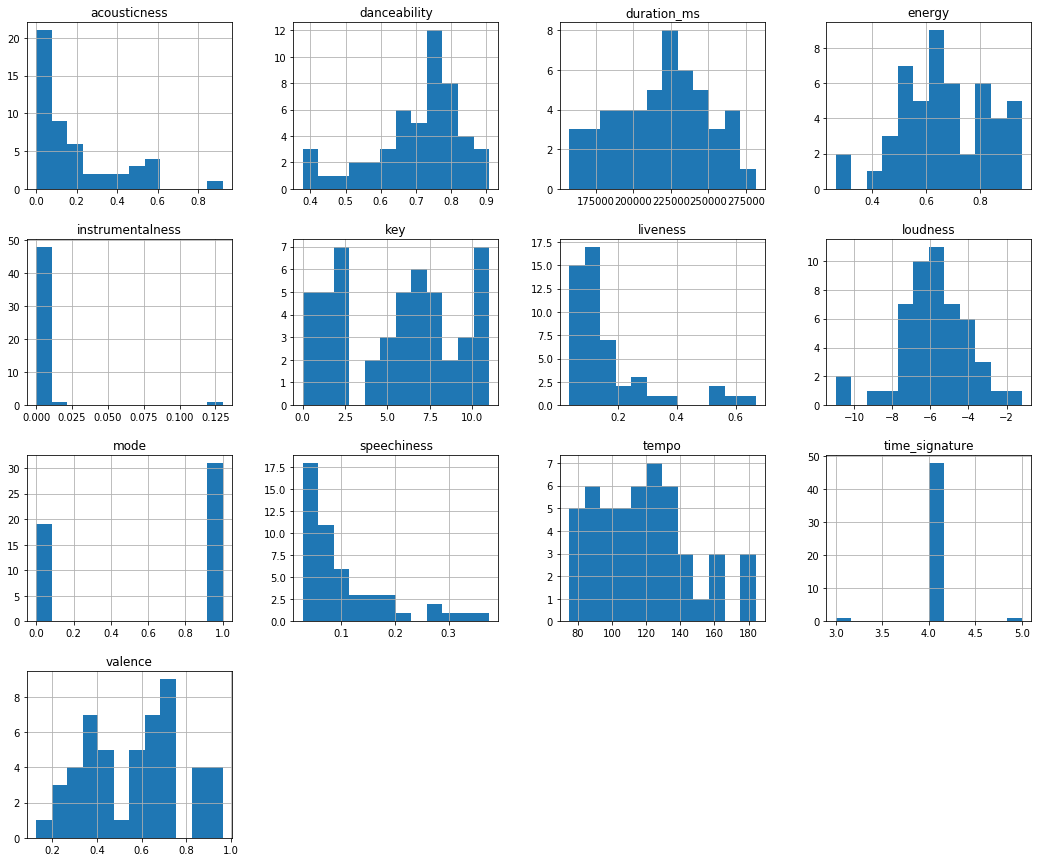

In [91]:
tens_df._get_numeric_data().hist(bins=12, figsize=(18, 15), layout=(4, 4));

Below I created a widget that allows me to choose from the songs in the playlist to show their respective audio features.

In [71]:
## Code block to make plotly visualization of top 50 of Spotify 2010s

song_choice = widgets.Dropdown(
    options=tens_df["Name"],
    value="One Dance",
    description='Song:',
)

s_layout = go.Layout(
    polar=dict(
        radialaxis=dict(
            visible=True,
            range=[0, 1]
        )
    ),
    showlegend=False,
    title="Spotify's Top 50 of the Decade: {}".format(song_choice.value)
)

#interactive(to_plot, graph = graph_choice, dat = data_choice)

top_50 = go.FigureWidget(data=[polar_song_stats(tens_df[tens_df["Name"] == "One Dance"])], layout=s_layout)

def validate(): 
    return True


def response(change):
    if validate():
        temp_df = tens_df[tens_df["Name"] == song_choice.value]

        x1 = polar_song_stats(temp_df)
        with top_50.batch_update():
            top_50.data[0].r = x1.r
            top_50.data[0].name = x1.name
            top_50.layout.title = title="Spotify's Top 50 of the Decade: {}".format(song_choice.value)
            #g.layout.barmode = 'overlay'
            #g.layout.xaxis.title = 'Delay in Minutes'
            #g.layout.yaxis.title = 'Number of Delays'


song_choice.observe(response, names="value")

widgets.VBox([song_choice,
              top_50])

In [72]:
#import plotly.express as px
#fig = px.scatter(tens_df, x="valence", y="energy", hover_data=['Name'])
#fig.update_xaxes(range=[0, 1])
#fig.update_yaxes(range=[0, 1])

fig = go.Figure(data=go.Scatter(
    x=tens_df["valence"],
    y=tens_df["energy"],
    mode='markers',
    marker=dict(size=tens_df["tempo"] / 10),
    hovertext = tens_df["Name"]
),
    layout = {
    'shapes': [
        # Line Horizontal
        {
            'type': 'line',
            'x0': 0,
            'y0': 0.5,
            'x1': 1,
            'y1': 0.5,
            'line': {
                'color': 'rgb(50, 171, 96)',
                'width': 2
            },
        }, 
        {
            'type': 'line',
            'x0': 0.5,
            'y0': 0,
            'x1': 0.5,
            'y1': 1,
            'line': {
                'color': 'rgb(50, 171, 96)',
                'width': 2
            },
        },
        
        {
            'type': 'line',
            'x0': 0,
            'y0': np.mean(tens_df["energy"]),
            'x1': 1,
            'y1': np.mean(tens_df["energy"]),
            'line': {
                'color': 'red',
                'width': 2
            },
        }, 
        {
            'type': 'line',
            'x0': np.mean(tens_df["valence"]),
            'y0': 0,
            'x1': np.mean(tens_df["valence"]),
            'y1': 1,
            'line': {
                'color': 'red',
                'width': 2
            },
        }
    ],
    'showlegend': False
})

fig.update_layout(
    autosize=False,
    width=600,
    height=600,
    title="Spotify Top 50 of the 2010s",
    xaxis_title="Valence",
    yaxis_title="Energy",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#7f7f7f"
    )
)


fig.update_xaxes(range=[0, 1])
fig.update_yaxes(range=[0, 1])

fig.show()
print("Valence:", np.mean(tens_df["valence"]))
print("Energy:", np.mean(tens_df["energy"]))

#layout(shapes = list(vline(4), hline(5)))

#fig.show()

Valence: 0.5732600000000001
Energy: 0.6638800000000002


Interestingly, we notice that the average energy of these songs is quite high. As described on the documentation of the API, energy is described to:

"...[represent] a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale."

While it may not say that these songs are all death metal, it gives a slight peek into the kind of music people may look for - music that pumps you up. 

There is a lot more analysis to be done to get a better understanding of our data, but this gives a foretaste into the capabilities of the Spotify API.

In [92]:
#songs = []

#s_layout = go.Layout(
#    polar=dict(
#        radialaxis=dict(
#            visible=True,
#            range=[0, 1]
#        )
#    ),
#    showlegend=False,
#    title="Spotify's Top 50 of the Decade"
#)

#for index, song in tens_df.iterrows():
#    songs.append(polar_song_stats(song, itr = True))
#
#compare_songs = go.Figure(data=songs, layout=s_layout)
#iplot(compare_songs, filename='Spotify''s Top 50 of the Decade')

What we will also do is save our dataframe of the data from the playlist so we can use it in other reports.

In [76]:
tens_df.head()

,Name,Artists,acousticness,analysis_url,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,track_href,type,uri,valence
0,One Dance,"[Drake, WizKid, Kyla]",0.00776,https://api.spotify.com/v1/audio-analysis/1zi7...,0.792,173987,0.625,1zi7xx7UVEFkmKfv06H8x0,0.001880,1,0.3290,-5.609,1,0.0536,103.967,4,https://api.spotify.com/v1/tracks/1zi7xx7UVEFk...,audio_features,spotify:track:1zi7xx7UVEFkmKfv06H8x0,0.370
1,Lean On (feat. MØ & DJ Snake),"[Major Lazer, MØ, DJ Snake]",0.00346,https://api.spotify.com/v1/audio-analysis/1qE4...,0.723,176561,0.809,1qE47wUKG2juJwPoLqg4C9,0.001230,7,0.5650,-3.081,0,0.0625,98.007,4,https://api.spotify.com/v1/tracks/1qE47wUKG2ju...,audio_features,spotify:track:1qE47wUKG2juJwPoLqg4C9,0.274
2,Sunflower - Spider-Man: Into the Spider-Verse,"[Post Malone, Swae Lee]",0.53300,https://api.spotify.com/v1/audio-analysis/0RiR...,0.755,157560,0.522,0RiRZpuVRbi7oqRdSMwhQY,0.000000,2,0.0685,-4.368,1,0.0575,89.960,4,https://api.spotify.com/v1/tracks/0RiRZpuVRbi7...,audio_features,spotify:track:0RiRZpuVRbi7oqRdSMwhQY,0.925
3,Somebody That I Used To Know,"[Gotye, Kimbra]",0.54800,https://api.spotify.com/v1/audio-analysis/1qDr...,0.865,244885,0.521,1qDrWA6lyx8cLECdZE7TV7,0.000115,0,0.0989,-6.932,1,0.0371,129.059,4,https://api.spotify.com/v1/tracks/1qDrWA6lyx8c...,audio_features,spotify:track:1qDrWA6lyx8cLECdZE7TV7,0.748
4,Rolling in the Deep,[Adele],0.13100,https://api.spotify.com/v1/audio-analysis/1Ckv...,0.729,228293,0.756,1CkvWZme3pRgbzaxZnTl5X,0.000000,8,0.0527,-5.119,1,0.0294,104.945,4,https://api.spotify.com/v1/tracks/1CkvWZme3pRg...,audio_features,spotify:track:1CkvWZme3pRgbzaxZnTl5X,0.522


In [83]:
tens_df.to_csv("top2010s.csv", index = False)